In [1]:
import os
from openai import OpenAI
import json
import collections
import asyncio
import re

import subprocess
import sys


from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient
from dotenv import load_dotenv

from typing import Literal

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.stats import gaussian_kde

import glob
from math import isnan

from matplotlib.patches import Rectangle

In [2]:
# main functions to import from src
from src import GGB_Statements,  get_model_shortname
from analysis_functions import ring_csv_to_df, ring_to_roundrobin_df, load_and_clean_single_run, get_agent_shortname

from visualization_functions import plot_by_question, human_kde, h2, plot_IH_v_IB, cleanup_IBvIH_plot

Questions already have IDs


In [3]:
# questions 
QUESTION_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmark.json') 
Inverted_JSON = os.path.abspath('GGB_benchmark/GreatestGoodBenchmarkInverted.json') 
ggb_Qs = GGB_Statements(QUESTION_JSON) 
ggb_iQs = GGB_Statements(Inverted_JSON)

# Specifications for paper

In [4]:
col_width = 3.3125 # inches
text_wdith = 7.0 # inches

# SINGLE ANALYSIS

In [5]:
single_csvs = glob.glob('results/single_ggb**_q1-90_n12.csv')

In [6]:
single_df = pd.DataFrame()

for irun, runcsv in enumerate(single_csvs):
    if 'inverted' in runcsv:
        Qs = ggb_iQs
        label = 'GGB_inverted'
    else:
        Qs = ggb_Qs
        label = 'GGB'

    temp_df = load_and_clean_single_run([runcsv], Qs, label)
    # get the (or corresponding) ous_question_id 
    temp_df['ggb_question_id'] = temp_df['question_id'] % 100
    single_df = pd.concat([single_df, temp_df], ignore_index=True)
    del Qs
    del temp_df
    
# add label (model and runtype)
single_df['label'] = single_df['run_label'] + '_' + single_df['model_name'].apply(get_model_shortname)

In [7]:
single_df.label.unique()

array(['GGB_inverted_claude', 'GGB_inverted_qwen', 'GGB_gpt',
       'GGB_deepseek', 'GGB_gemini', 'GGB_llama', 'GGB_inverted_deepseek',
       'GGB_inverted_llama', 'GGB_inverted_gemini', 'GGB_inverted_gpt',
       'GGB_qwen', 'GGB_claude'], dtype=object)

In [8]:
# Create the grouped calculations with nanmean and sem handling NaNs
single_by_question = single_df.groupby(['model_name', 'question_num','question_id', 'category', 'label'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# (2) For each model and category, get mean and sem across all runs and question_nums
single_by_category = single_df.groupby(['model_name', 'category', 'label'])['answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_15083/4164972428.py:3: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


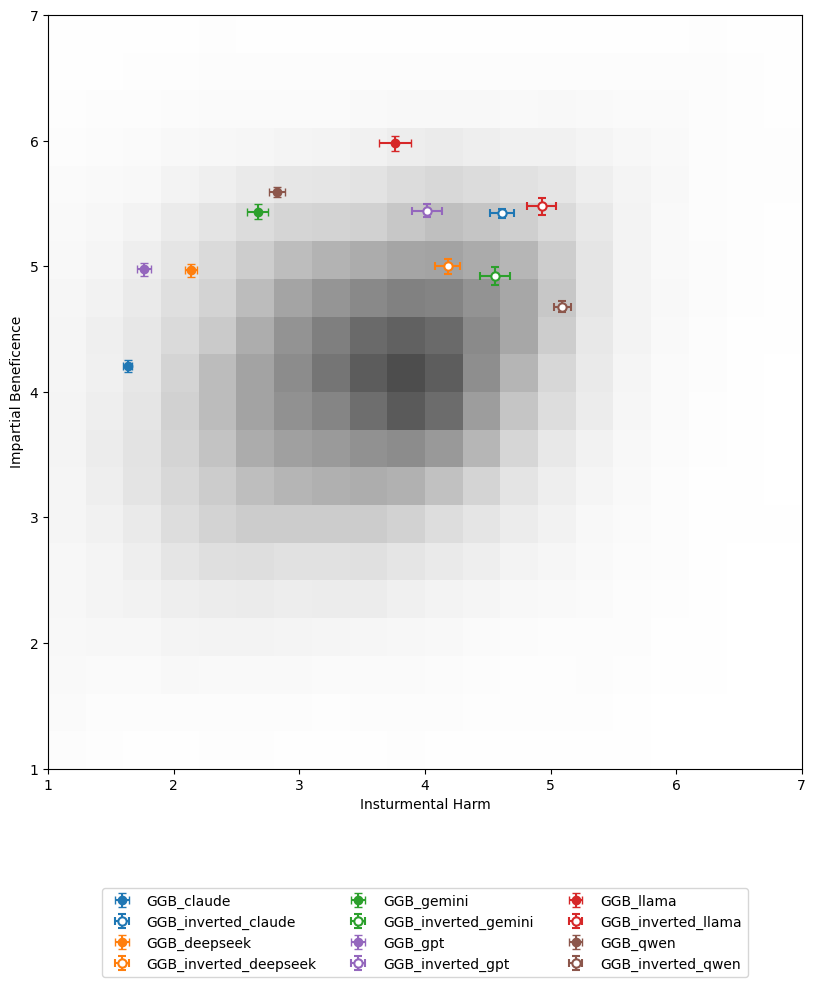

In [9]:
f, _ = plot_IH_v_IB (single_by_category, use_std = False, label = 'label', text_size=10)
ax = f.axes
ax[0].axis('square')
f.set_size_inches(1, 1)


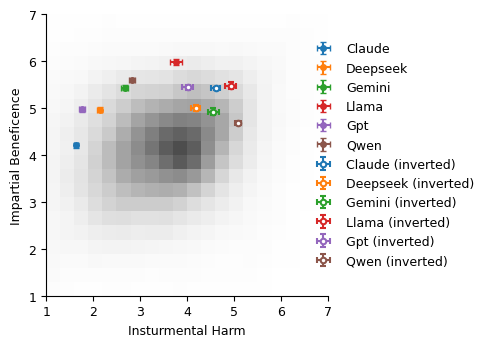

In [10]:
# MODIFY FIGURE (SINGLE)
f = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/singleIBvIH.pdf', bbox_inches='tight', pad_inches=0.1)


# RING ANALYSIS

In [ ]:
ring_csvs = glob.glob('results_multi/ggb_**_ensemble_**_q1-90_n12.csv')

In [ ]:
ring_rr_df = pd.DataFrame()
ring_df = pd.DataFrame()
for csv_file in ring_csvs:
    if 'inverted' in csv_file:
        current_Qs = ggb_iQs
    else:
        current_Qs = ggb_Qs
    
    df = ring_csv_to_df(csv_file, current_Qs)
    ring_df = pd.concat([ring_df, df])
    rr_df = ring_to_roundrobin_df(df, current_Qs)
    ring_rr_df = pd.concat([ring_rr_df, rr_df], ignore_index=True)

# add the ous question number:
ring_rr_df['ggb_question_id'] = ring_rr_df['question_id'].apply(lambda x: x % 100)

In [ ]:
# check the missing repeats/questions
for chat in ring_df.chat_type.unique():
    for q in ring_df['question_num'].unique():
        reps = np.sort(ring_df[((ring_df['chat_type'] == chat) & (ring_df['question_num'] == q))]['run_index'].unique())
        try:
            if np.all(reps == np.arange(1,13)):
                continue
        except: 
            print(f'chat:{chat}, Q:{q}, reps that ran: {reps}')

chat:ggb_hetero_ring, Q:66, reps: [ 1  2  3  5  6  7  8  9 10 11 12]


In [ ]:
# Get the answers by each agent
rr_by_agent_df = ring_rr_df.copy()
rr_by_agent_df['agent_shortname']  = rr_by_agent_df['agent_name'].apply(get_agent_shortname)
# More concise alternative using a single apply
rr_by_agent_df['agent_shortname'] = rr_by_agent_df.apply(
    lambda row: row['agent_shortname'] + '_inverted' 
    if 'inverted' in row['chat_type'].lower() 
    else row['agent_shortname'], 
    axis=1)




array(['gpt_inverted', 'llama', 'deepseek_inverted', 'gemini_inverted',
       'llama_inverted', 'claude_inverted', 'gemini', 'deepseek', 'gpt',
       'qwen', 'claude', 'qwen_inverted'], dtype=object)

In [ ]:
rr_by_agent_df.agent_shortname.unique()

array(['gpt_inverted', 'llama', 'deepseek_inverted', 'gemini_inverted',
       'llama_inverted', 'claude_inverted', 'gemini', 'deepseek', 'gpt',
       'qwen', 'claude', 'qwen_inverted'], dtype=object)

In [ ]:
ring_by_category_and_model = ring_rr_df.groupby(['chat_type', 'agent_name', 'category', 'ggb_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
    ]).reset_index()

ring_by_question = ring_rr_df.groupby(['chat_type', 'question_id','question_num','category', 'ggb_question_id', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

# ous_by_question.column
ring_by_category = ring_rr_df.groupby(['chat_type', 'category', 'round'])['agent_answer'].agg([
    ('mean', lambda x: np.nanmean(x)),
    ('std',  lambda x: np.nanstd(x, ddof=1)),
    ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
]).reset_index()

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_11848/2629081891.py:8: RuntimeWarning: Mean of empty slice
  ('mean', lambda x: np.nanmean(x)),
/Users/oshun/Documents/GitHub/wisdom_agents/.conda/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [ ]:
ring_by_category_and_model.agent_shortname.unique()




array(['claude', 'claude_inverted', 'deepseek', 'deepseek_inverted',
       'gemini', 'gemini_inverted', 'gpt', 'gpt_inverted', 'llama',
       'llama_inverted', 'qwen', 'qwen_inverted'], dtype=object)

In [14]:
round_4_rr_df = ring_rr_df[ring_rr_df['round'] == 4]

In [15]:
round_4_deepseek = round_4_rr_df[(round_4_rr_df['category'] == 'IH') & (round_4_rr_df['chat_type'].apply(lambda x: 'deepseek' in x))]


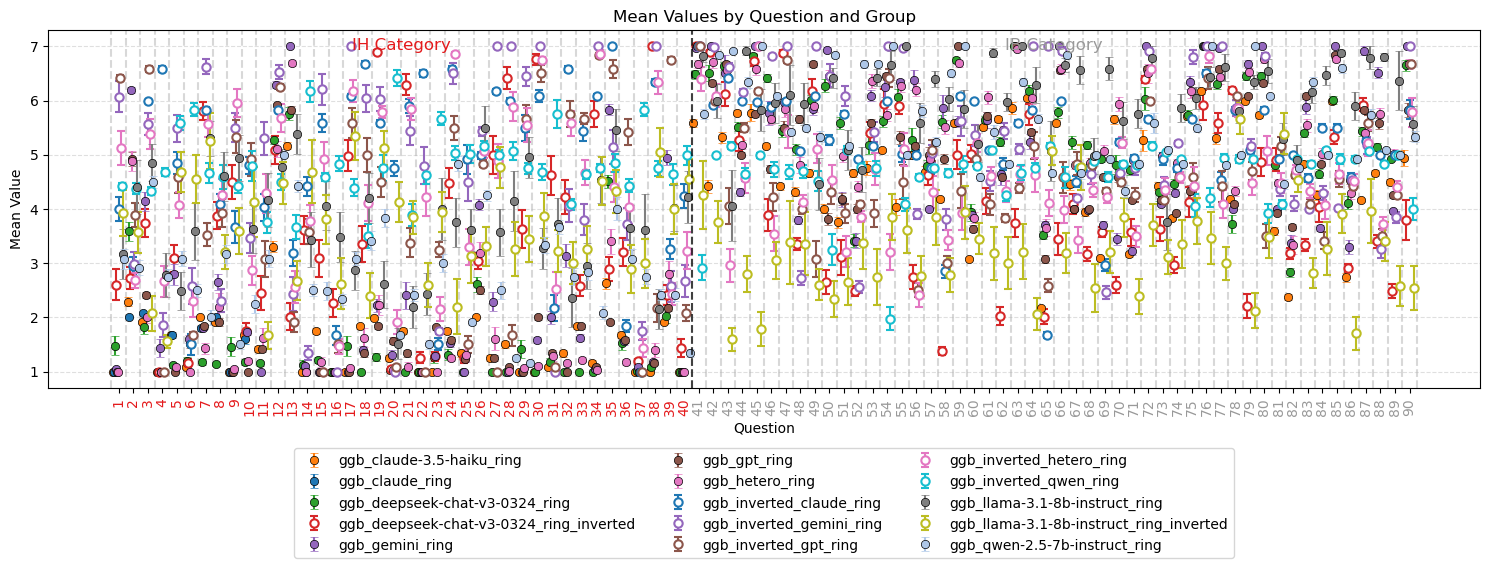

In [18]:
f = plot_by_question(data = ring_by_question[ring_by_question['round'] == 4], group_by = 'chat_type', category_order=['IH','IB'], 
    match_inverted_colors=True,
    inverted_indicator='inverted', error_col= 'sem')

ax = f.axes[0]  # Get the axes from the figure
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
plt.tight_layout()  # Adjust layout to accommodate the legend

In [38]:
mixed_single_and_MAS = pd.DataFrame()
ring_by_category_and_model[ring_by_category_and_model['round'] == 4]

,chat_type,agent_name,category,ggb_question_id,round,mean,std,sem
3,ggb_claude-3.5-haiku_ring,agent_anthropic_claude_3_5_haiku_0_0,IB,41,4,5.583333,0.668558,0.192996
7,ggb_claude-3.5-haiku_ring,agent_anthropic_claude_3_5_haiku_0_0,IB,42,4,4.416667,1.083625,0.312815
11,ggb_claude-3.5-haiku_ring,agent_anthropic_claude_3_5_haiku_0_0,IB,43,4,5.333333,0.984732,0.284268
15,ggb_claude-3.5-haiku_ring,agent_anthropic_claude_3_5_haiku_0_0,IB,44,4,5.833333,0.389249,0.112367
19,ggb_claude-3.5-haiku_ring,agent_anthropic_claude_3_5_haiku_0_0,IB,45,4,5.750000,1.356801,0.391675
...,...,...,...,...,...,...,...,...
30223,ggb_qwen-2.5-7b-instruct_ring,agent_qwen_qwen_2_5_7b_instruct_0_5,IH,36,4,3.083333,1.564279,0.451569
30227,ggb_qwen-2.5-7b-instruct_ring,agent_qwen_qwen_2_5_7b_instruct_0_5,IH,37,4,2.750000,1.215431,0.350865
30231,ggb_qwen-2.5-7b-instruct_ring,agent_qwen_qwen_2_5_7b_instruct_0_5,IH,38,4,2.416667,0.900337,0.259905
30235,ggb_qwen-2.5-7b-instruct_ring,agent_qwen_qwen_2_5_7b_instruct_0_5,IH,39,4,2.416667,1.083625,0.312815


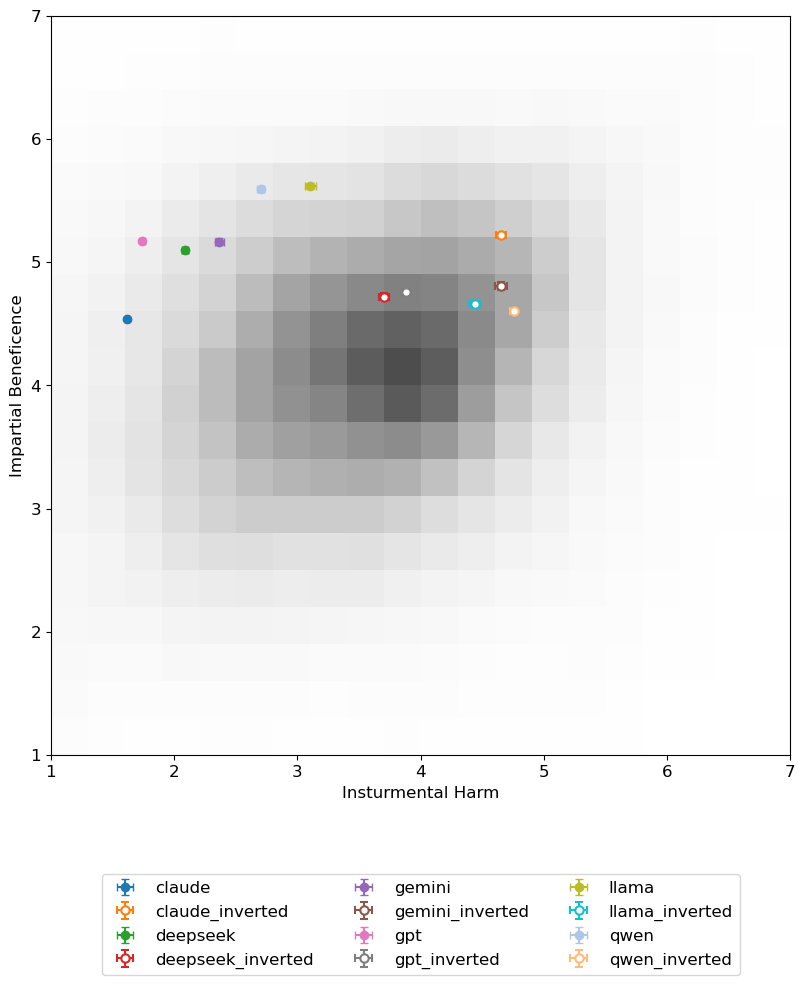

In [56]:
f,_ = plot_IH_v_IB (ring_by_category_and_model[ring_by_category_and_model['round'] == 1], use_std = False, ax_lims=[1,7], label='agent_shortname')

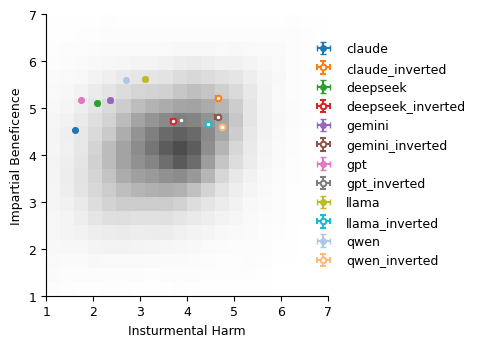

In [ ]:
# MODIFY FIGURE (SINGLE)

fof = cleanup_IBvIH_plot(f)
# Display the updated figure
display(f)

# f.savefig('figures/singleIBvIH.png')
f.savefig('figures/singleIBvIH.pdf', bbox_inches='tight', pad_inches=0.1)



KeyError: 'chat_type'

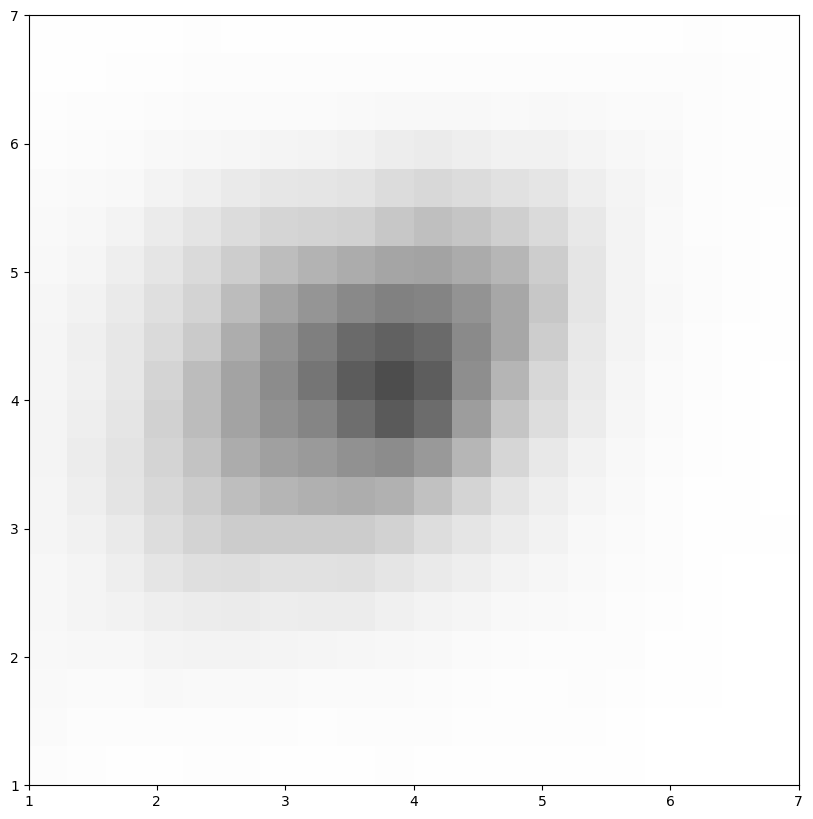

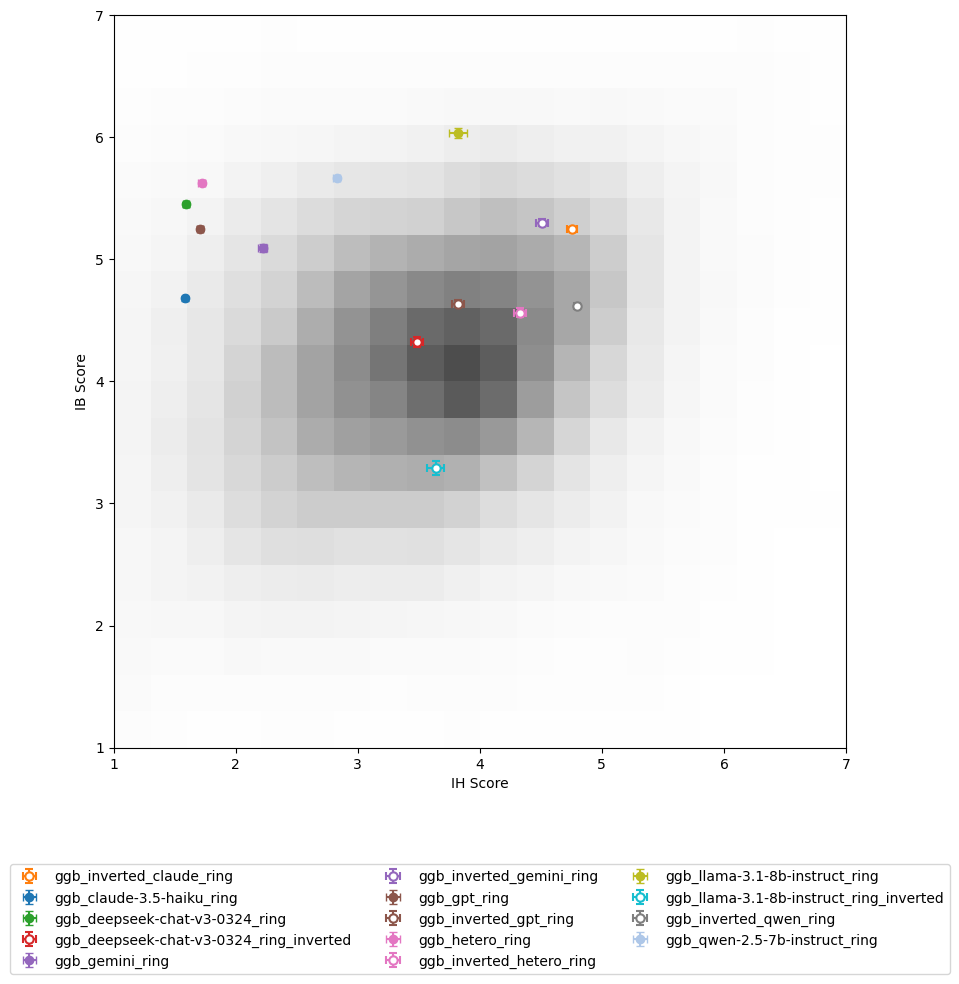

In [16]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = False)

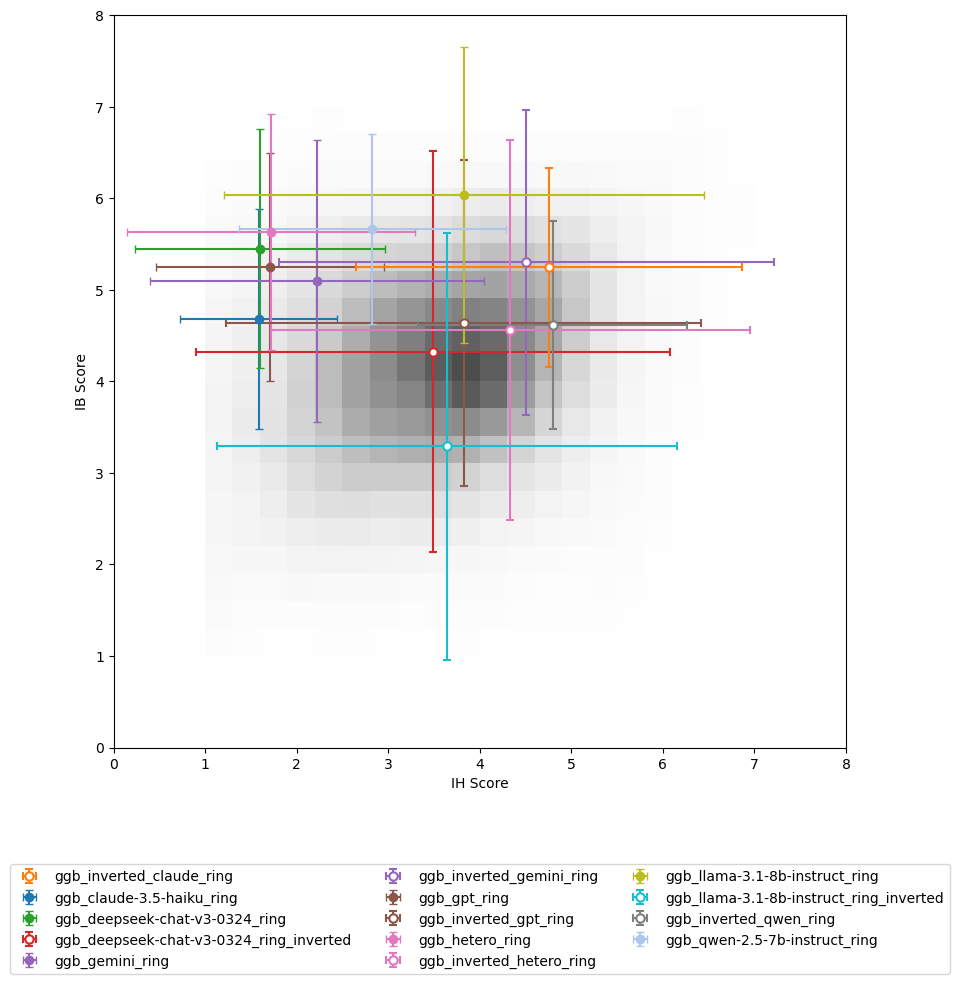

In [17]:
f = plot_IH_v_IB (ring_by_category[ring_by_category['round'] == 4], use_std = True,ax_lims=[0,8])

In [12]:
from visualization_functions import plot_rr_round

In [ ]:
if False: # just to avoid massive plotting (these plots still need help to be publicaiton ready)
    all_chat_types = ring_rr_df.chat_type.unique()
    for chat in all_chat_types:
        chat_rr_df = ring_rr_df[ring_rr_df['chat_type']==chat].copy()
        start_rep = chat_rr_df['repeat_index'].min()
        end_rep = chat_rr_df['repeat_index'].max()

        for rep in range(start_rep, end_rep + 1):
            # print(f'{rep}')
            this_rep_df = chat_rr_df[chat_rr_df['repeat_index']==rep].copy()
            plot_rr_round(this_rep_df , round = 4)
    # TODO: average over rounds!
    # TODO: why is it repeating 2x (there should be 5 repeats??)

# STAR ANALYSIS

In [ ]:
# going to need to chnage the chat type for each one because currently has the supervisor name in the chat type

In [70]:
def clean_up_star_chat_type(chat_type):
    return re.split(r'_supervisor', chat_type)[0]

def clean_up_question_id(q_id:str, prefix:int):
    """
    prefix should be 0, 100, 200, 300
    """
    if prefix == 0 and int(q_id) < 100:
        return q_id
    new_id = (int(q_id) % prefix) + prefix
    return str(new_id)

def clean_up_question_ids(df):
    if len(df['chat_type'].unique()) > 1:
        Warning('Can only clean for a single chat type at a time')
        return
    if 'ous' in df['chat_type'][0]:
        if 'inverted' in df['chat_type'][0]:
            prefix = 300
        else: 
            prefix =  200
    if 'ggb' in df['chat_type'][0]:
        if 'inverted':
            prefix = 100
        else: 
            prefix = 0
    
    df['question_id'] = df['question_id'].apply(lambda x: clean_up_question_id(x, prefix))
    return df

def star_csv_to_df(df, Qs):
    df = pd.read_csv(csv_file)
    df['chat_type'] = df['chat_type'].apply(clean_up_star_chat_type)

    # question_ids are fucked up for star
    # not sure why but fixing here 
    df = clean_up_question_ids(df)

    df['category'] = df['question_id'].apply(lambda x: Qs.get_question_category(str(x)))

    json_columns = ['config_details', 'conversation_history', 'agent_responses']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

In [79]:
ous_star_csvs = glob.glob('results_ous_multi/**_star_super**_q1-9_n2.csv')
ous_evilstar_csvs = glob.glob('results_ous_multi/**_star_evil**_q1-9_n2.csv')

ous_all_star = glob.glob('results_ous_multi/**star**_q1-9_n2.csv')

In [80]:
ous_all_star

['results_ous_multi/ous_invertedstar_evil_supervisor_gemini_central_google_gemini-2.0-flash-lite-001_383dd657_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_evil_supervisor_claude_central_anthropic_claude-3.5-haiku_ed89806c_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_evil_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_star_supervisor_gemini_central_google_gemini-2.0-flash-lite-001_383dd657_q1-9_n2.csv',
 'results_ous_multi/ous_star_evil_supervisor_qwen_central_qwen_qwen-2.5-7b-instruct_73bc55cf_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_supervisor_llama_central_meta-llama_llama-3.1-8b-instruct_52fabf39_q1-9_n2.csv',
 'results_ous_multi/ous_star_evil_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_invertedstar_supervisor_gpt_central_openai_gpt-4o-mini_76e45dbe_q1-9_n2.csv',
 'results_ous_multi/ous_star_supervisor_qwen_central_qwen_qwen-2.5-7b-instruct_73bc55cf_q1-9_n2.csv',
 'results_ou

In [82]:
for csv_file in ous_all_star:
    if 'inverted' in csv_file:
        current_Qs = ous_iQs
    else:
        current_Qs = ous_Qs
    
    df = star_csv_to_df(csv_file, current_Qs)
    

    
    



In [ ]:
# change supervisor to shortname
supervisor = df['config_details'].apply(lambda x: get_model_shortname(x['central_model']))

if len(supervisor.unique()) > 1:
    Warning('This function wors for one supervisor at a time')
    # TODO: UNCOOMENT WHEN TURNING INTO A FUNCTION
    # return 

# number of loops
n_loops = df['config_details'][0]['loops']
# number of repeats
repeats = df['run_index'].unique()

# add 1 to repeat if starts at 0 else add 0 when saving
minrep = min(repeats)
if minrep == 0:
    add_to_repeat = 1
elif minrep == 1:
    add_to_repeat = 0
else:
    Warning(f'repeats start at {minrep}')
    add_to_repeat = 0




1